<a href="https://colab.research.google.com/github/zhichucode/Audio/blob/master/sound_data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sound anomaly detection
*Step 1 - Data exploration*

## Introduction
---

There are usually very few redondancies on a manufacturing production line of any shop floor. The ability to ensure the highest avaibility of these lines is key to deliver higher ROI, produce better quality products, increase safety levels, reduce environmental impact and waste and in the end... ensure greater customer satisfaction. More and more AI-based solutions are leveraging sensor data coming from the pieces of equipment on the production line. In this example, we are going to use sounds recorded in an industrial environment to perform anomaly detection on indsutrial equipment.

To achieve this, we are going to explore and leverage the MIMII dataset for anomaly detection purpose: this is a sound dataset for **M**alfunctioning **I**ndustrial **M**achine **I**nvestigation and **I**nspection (MIMII). It can be downloaded from **[this link](https://zenodo.org/record/3384388#.X2werWgzaTk)** and contains sounds from several types of industrial machines (valves, pumps, fans and slide rails). In this example, we are going to focus on the **fans**.

This is the first notebook in a series of three:
* This notebook will help you get familiar with this kind of data. Sound data are particular time series data and exploring them requires specific approaches.
* In the next notebook we will build an autoencoder to build a classifier able to discriminate between normal and abnormal sounds.
* Lastly, we are going to take on a more novel approach in the last part of the work: we are going to transform the sound files into spectrogram images and feed them to an image classifier. We will use Amazon Rekognition Custom Labels to perform this work.

The two approaches (building a basic autoencoder from scratch and leveraging Rekognition) amounts approximately to the same effort: although the models are in no way comparable it will give you an idea of how much of a kick start you can get when using an applied AI service (if any).

## Initialization
---
**WARNING**: make sure you run this notebook using an **ml.c5.2xlarge instance** with a **25 GB attached EBS volume** to process the MIMII dataset (the dataset for the industrial fans is a 10 GB archive, reaching 14 GB once unzipped).

### Configuration
Remove the **-q** command line parameters if you want to check for potential error messages.

In [1]:
# Notebook update
import sys
import librosa

!pip -q install --upgrade sagemaker
#if 'librosa' not in list(sys.modules):
#    !conda install -q -y -c conda-forge librosa

# Kernel restart
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

     |████████████████████████████████| 513 kB 12.7 MB/s 
     |████████████████████████████████| 49 kB 4.9 MB/s 
     |████████████████████████████████| 132 kB 34.0 MB/s 
     |████████████████████████████████| 81 kB 7.4 MB/s 
     |████████████████████████████████| 8.6 MB 37.5 MB/s 
     |████████████████████████████████| 79 kB 5.8 MB/s 
     |████████████████████████████████| 138 kB 36.7 MB/s 
     |████████████████████████████████| 65 kB 2.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.8 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
!pip install -U python-utils

In [3]:
# Python libraries:
import hashlib
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import sys

# Sound management:
import librosa
import librosa.display
import IPython.display as ipd

sys.path.append('tools')
#import utils
#import sound_tools

In [4]:
# Initialization:
random.seed(42)
np.random.seed(42)
plt.style.use('Solarize_Light2')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
blue, red = colors[1], colors[5]

# Paths definition:
DATA           = os.path.join('data', 'interim')

RAW_DATA       = os.path.join('data', 'raw')
PROCESSED_DATA = os.path.join('data', 'processed')

In [12]:
print(DATA)

data/interim


### Loading helper functions

### Downloading and unzipping data

In [5]:
if not os.path.exists(DATA):
    print('Data directory does not exist, creating them.')
    os.makedirs(DATA, exist_ok=True)
    os.makedirs(RAW_DATA, exist_ok=True)
    os.makedirs(PROCESSED_DATA, exist_ok=True)

Data directory does not exist, creating them.


In [6]:
# Checks if the dataset is already downloded and unzipped:
first_file = os.path.join(DATA, 'fan', 'id_00', 'normal', '00000000.wav')
if os.path.exists(first_file):
    print('=== Sound files found, no need to download them again. ===') # the code are good
    
else:
    print('=== Downloading and unzipping the FAN file from the MIMII dataset website (~10 GB) ===')
    !wget https://zenodo.org/record/3384388/files/6_dB_fan.zip?download=1 --output-document=/tmp/fan.zip
    
    # Checking file integrity: computing MD5 hash
    #original_md5 = '0890f7d3c2fd8448634e69ff1d66dd47'
    #downloaded_md5 = utils.md5('/tmp/fan.zip')
    
    # Correct MD5, unzipping archive:
    #if original_md5 == downloaded_md5:
    !unzip -q /tmp/fan.zip -d $DATA
        
    # Raising exception for an incorrect MD5:
    #else:
        #raise Exception('Downloaded file was corrupted, retry the download.')

=== Downloading and unzipping the FAN file from the MIMII dataset website (~10 GB) ===
--2022-03-13 07:55:46--  https://zenodo.org/record/3384388/files/6_dB_fan.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10158673161 (9.5G) [application/octet-stream]
Saving to: ‘/tmp/fan.zip’

/tmp/fan.zip        100%[===================>]   9.46G   108MB/s    in 1m 59s  

2022-03-13 07:57:46 (81.1 MB/s) - ‘/tmp/fan.zip’ saved [10158673161/10158673161]



NameError: ignored

In [7]:
!unzip -q /tmp/fan.zip -d $DATA

### Feature engineering parameters
These parameters are used to extract features from sound files:

In [8]:
n_mels = 64
frames = 5
n_fft = 2048
hop_length = 512
power = 2.0

## Exploratory data analysis
---
Let's load a normal and an abnormal signal to plot them. Each recording contains **8 channels, one for each microphone** that was used to record the machine sound. For the remaining of this experiment, **we will only focus on the recordings of the first microphone**.
### Wave forms

In [9]:
! pip install sound_tools
samples, sampling_rate = librosa.load(file_path)


ERROR: Could not find a version that satisfies the requirement sound_tools (from versions: none)
ERROR: No matching distribution found for sound_tools


In [10]:
normal_signal_file = os.path.join(DATA, 'fan', 'id_00', 'normal', '00000100.wav')
abnormal_signal_file = os.path.join(DATA, 'fan', 'id_00', 'abnormal', '00000100.wav')
normal_signal, sr = librosa.load(normal_signal_file)
abnormal_signal, sr = librosa.load(abnormal_signal_file)
print(f'The signals have a {normal_signal.shape} shape. At {sr} Hz, these are {normal_signal.shape[0]/sr:.0f}s signals')

The signals have a (220500,) shape. At 22050 Hz, these are 10s signals


Let's first visualize the waveplots for these signals:

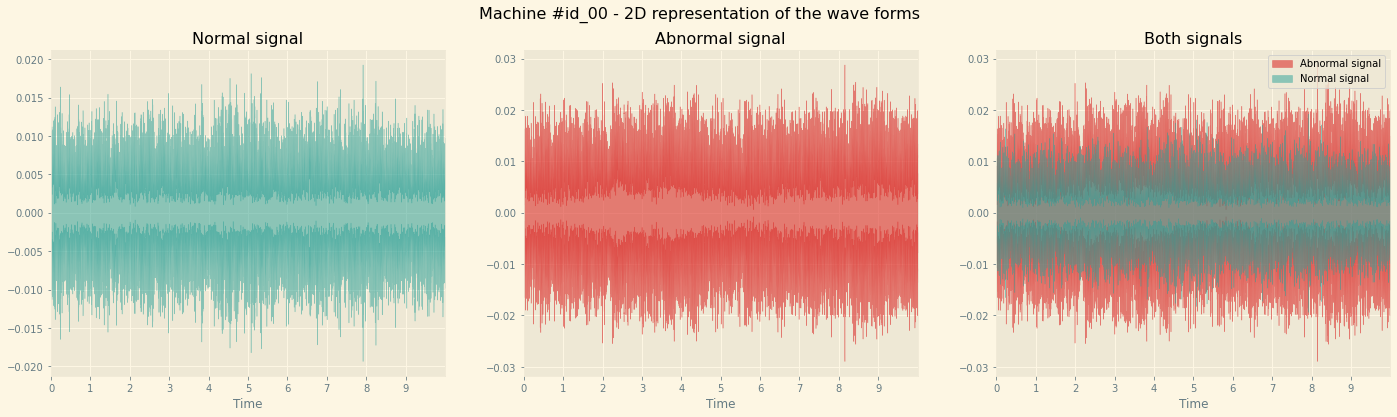

In [13]:
fig = plt.figure(figsize=(24, 6))
plt.subplot(1,3,1)
librosa.display.waveplot(normal_signal, sr=sr, alpha=0.5, color=blue, linewidth=0.5, label='Machine #id_00 - Normal signal')
plt.title('Normal signal')

plt.subplot(1,3,2)
librosa.display.waveplot(abnormal_signal, sr=sr, alpha=0.6, color=red, linewidth=0.5, label='Machine #id_00 - Abnormal signal')
plt.title('Abnormal signal')

plt.subplot(1,3,3)
librosa.display.waveplot(abnormal_signal, sr=sr, alpha=0.6, color=red, linewidth=0.5, label='Abnormal signal')
librosa.display.waveplot(normal_signal, sr=sr, alpha=0.5, color=blue, linewidth=0.5, label='Normal signal')
plt.title('Both signals')

fig.suptitle('Machine #id_00 - 2D representation of the wave forms', fontsize=16)
plt.legend();

Apart from the larger amplitude of the abnormal signal and some pattern that are more irregular, it's difficult to distinguish between these two signals. Let's listen to them:

In [14]:
ipd.Audio(os.path.join(DATA, 'fan', 'id_00', 'normal', '00000003.wav'), rate=sr)

In [15]:
ipd.Audio(os.path.join(DATA, 'fan', 'id_00', 'abnormal', '00000003.wav'), rate=sr)

We can hear a small difference. **Let's now have a look in the frequency domain** and see if we can make that difference more obvious...

### Short Fourier transform
Let's take the Fourier transform of a first time window. Such signals are highly non-stationary (i.e., their statistics change over time). As a consequence, it will be rather meaningless to compute a single Fourier transform over an entire signal. The short-time Fourier transform is obtained by computing the Fourier transform for successive frames in a signal. We can compute it thanks to the **`librosa.stft()`** function that returns a complex-valued matrix D where:
* `np.abs(D[f, t])` is the magnitude of frequency bin **f** at frame **t** and
* `np.angle(D[f, t])` is the corresponding phase for the same frequency bin **f** at frame **t**.

The parameter `n_fft` of this function is the length of the window signal (frame size) while the `hop_length` is the frame increment. Our signals are 10s long: with `n_fft = 2048` and at a sampling rate of 16 kHz, this corresponds to a physical duration of `2048/16000 = 128 ms`. Let's display the FFT of the first 128ms window (by limiting the signal span and by setting a hop length greater than `n_fft`):

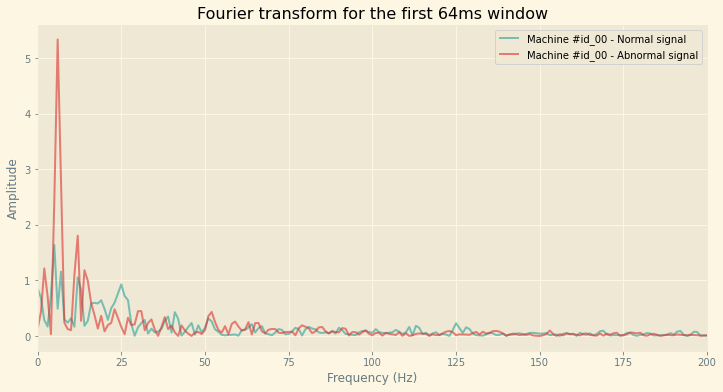

In [16]:
D_normal = np.abs(librosa.stft(normal_signal[:n_fft], n_fft=n_fft, hop_length=n_fft + 1))
D_abnormal = np.abs(librosa.stft(abnormal_signal[:n_fft], n_fft=n_fft, hop_length=n_fft + 1))

fig = plt.figure(figsize=(12, 6))
plt.plot(D_normal, color=blue, alpha=0.6, label='Machine #id_00 - Normal signal');
plt.plot(D_abnormal, color=red, alpha=0.6, label='Machine #id_00 - Abnormal signal');
plt.title('Fourier transform for the first 64ms window')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.xlim(0, 200);

### Spectrograms
Let's know take the entire signals, separate them in time windows of `hop_length` width, apply a short Fourier transform on each of these windows and plot them on a spectrogram to illustrate these three dimensions:
* Frequency (Hz) is now on the vertical axis
* Amplitude is shifted from the vertical axis of the previous diagram to the color axis
* The horizontal axis represents time

The following diagram is a plot of the short Fourier transforms for 20 bins (20 x 128ms = 2560ms which is the span of the horizontal axis) for the first 500 Hz (frequency span on the vertical axis):

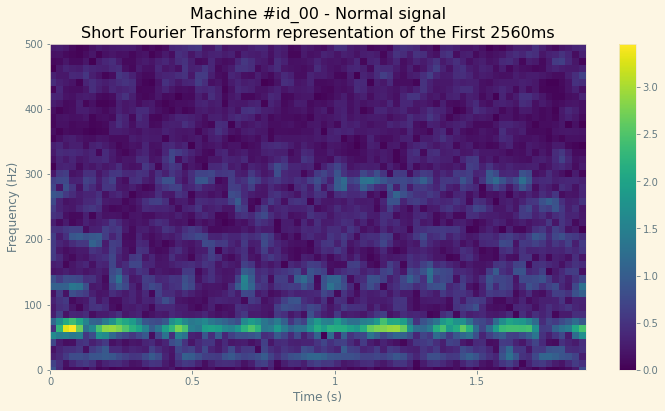

In [18]:
D_normal = np.abs(librosa.stft(normal_signal[:20*n_fft], n_fft=n_fft, hop_length=hop_length))

#dB_normal = sound_tools.get_magnitude_scale(normal_signal_file)

fig = plt.figure(figsize=(12, 6))
librosa.display.specshow(D_normal, sr=sr, x_axis='time', y_axis='linear', cmap='viridis');
plt.title('Machine #id_00 - Normal signal\nShort Fourier Transform representation of the First 2560ms')
plt.ylim(0, 500)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.show()

Let's now plot the same spectrogram for the whole signal (10s), a higher frequency range and for both a normal and an abnormal signals. Each spectrogram will have a dimension of `int(160,000 / hop_length) + 1 = 313` bins on the horizontal axis and `n_fft / 2 = 1,024` bins on the vertical axis. Hence, the dimension of the spectrogram for a given sound signal will be `1,024 x 313`.

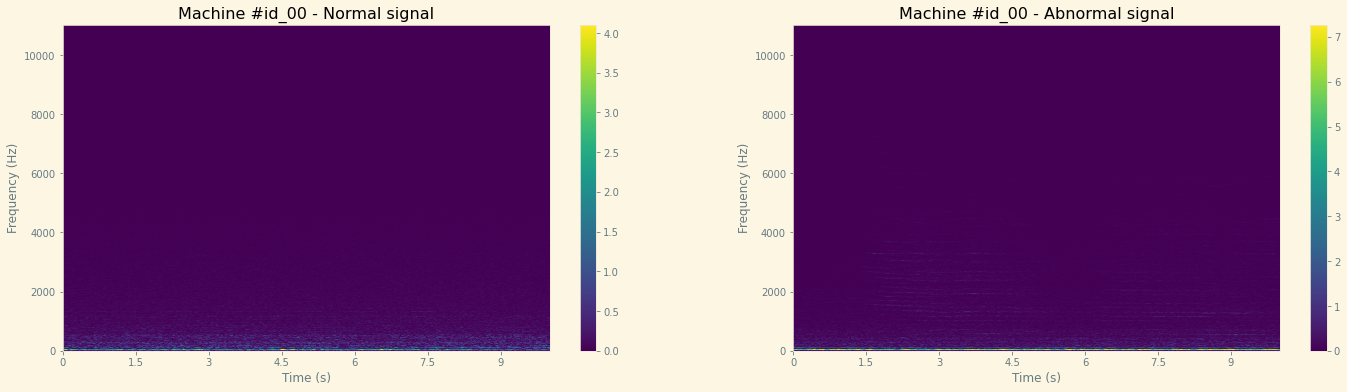

In [19]:
D_normal = np.abs(librosa.stft(normal_signal, n_fft=n_fft, hop_length=hop_length))
D_abnormal = np.abs(librosa.stft(abnormal_signal, n_fft=n_fft, hop_length=hop_length))

fig = plt.figure(figsize=(24, 6))
plt.subplot(1, 2, 1)
librosa.display.specshow(D_normal, sr=sr, x_axis='time', y_axis='linear', cmap='viridis');
plt.title('Machine #id_00 - Normal signal')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar();

plt.subplot(1, 2, 2)
librosa.display.specshow(D_abnormal, sr=sr, x_axis='time', y_axis='linear', cmap='viridis');
plt.title('Machine #id_00 - Abnormal signal')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar();

Not much we can see here, mainly because most sounds we can hear or experience as humans, are concentrated in a very small range (both in frequency and amplitude range). Let's take a log scale for both the frequency and the amplitude: for the amplitude, we obtain this by transforming the "color" axis to a log scale by converting it to Decibels (which is equivalent to applying a log scale to the sound amplitudes):

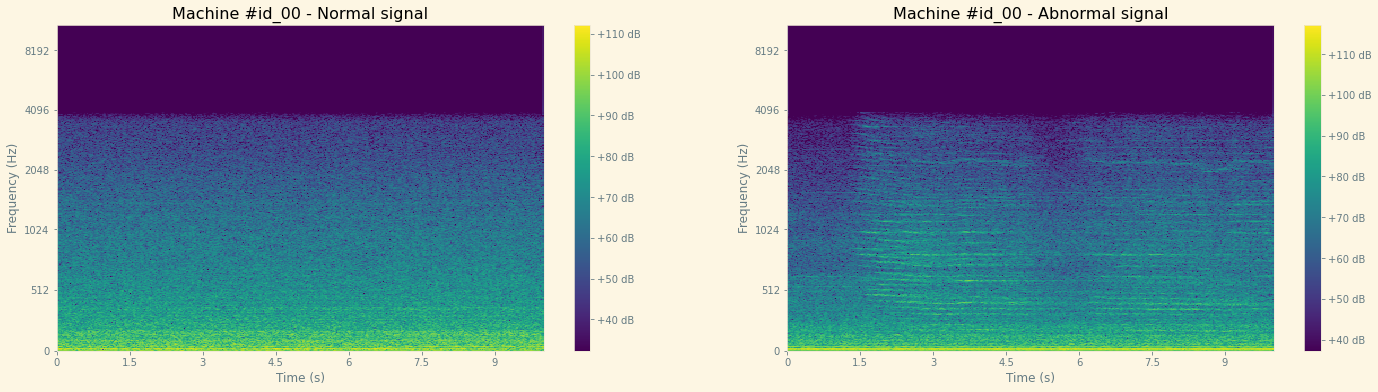

In [24]:
dB_normal = librosa.amplitude_to_db(D_normal, ref=np.min)
dB_abnormal = librosa.amplitude_to_db(D_abnormal, ref=np.min)

#mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)

fig = plt.figure(figsize=(24, 6))

plt.subplot(1, 2, 1)
librosa.display.specshow(dB_normal, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
plt.title('Machine #id_00 - Normal signal')
plt.colorbar(format="%+2.f dB")
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

plt.subplot(1, 2, 2)
librosa.display.specshow(dB_abnormal, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
plt.title('Machine #id_00 - Abnormal signal')
plt.ylabel('Frequency (Hz)')
plt.colorbar(format="%+2.f dB")
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

plt.show()

### Applying Mel scale
The way the Mel scale is constructed is to allow sounds that are at equal distance from each other on this scale, to also *sound* as if they were at equal distance if a human hear them. As a human, our ear is easily able to distinguish two sounds at frequency 250 Hz and 500 Hz. However, we will barely notice any difference between two other sounds emitted at frequency 9750 Hz and 10000 Hz (which are still 250 Hz apart)... This non-linear transformation is also available in the `librosa` library. The following function partitions the frequency scales in bins and transform each of them into the corresponding bin in the Mel scale: this produces a linear transformation matrix to project FFT bins onto Mel-frequency bins. Then it uses this transformation matrix to plot a new spectrogram:

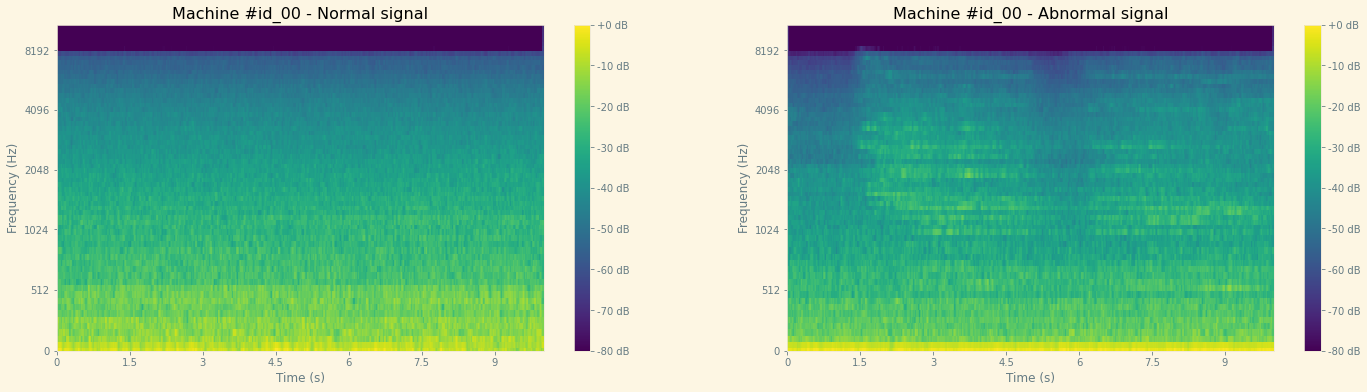

In [25]:
normal_mel = librosa.feature.melspectrogram(normal_signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
normal_S_DB = librosa.power_to_db(normal_mel, ref=np.max)
abnormal_mel = librosa.feature.melspectrogram(abnormal_signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
abnormal_S_DB = librosa.power_to_db(abnormal_mel, ref=np.max)

fig = plt.figure(figsize=(24, 6))
plt.subplot(1, 2, 1)
librosa.display.specshow(normal_S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', cmap='viridis');
plt.title('Machine #id_00 - Normal signal')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(format='%+2.0f dB');

plt.subplot(1, 2, 2)
librosa.display.specshow(abnormal_S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', cmap='viridis');
plt.title('Machine #id_00 - Abnormal signal')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(format='%+2.0f dB');

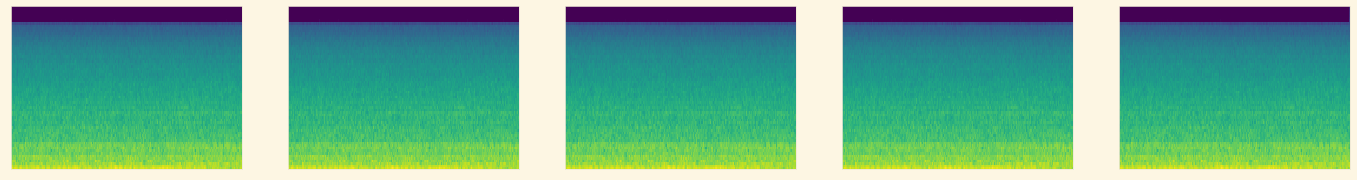

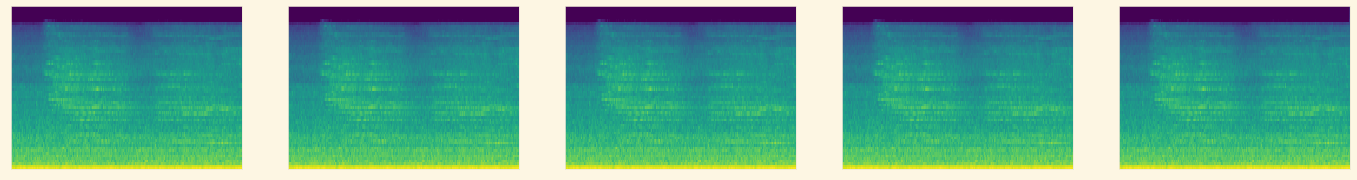

In [26]:
frames = 5
stride = 1
dims = frames * n_mels

features_vector_size = normal_S_DB.shape[1] - frames + 1
features = np.zeros((features_vector_size, dims), np.float32)
for t in range(frames):
    features[:, n_mels * t: n_mels * (t + 1)] = normal_S_DB[:, t:t + features_vector_size].T
fig = plt.figure(figsize=(24, 3))
for t in range(frames):
    plt.subplot(1, frames, t + 1)
    librosa.display.specshow(features[:, n_mels * t: n_mels * (t + 1)].T, sr=sr, hop_length=hop_length, cmap='viridis');
    
features_vector_size = abnormal_S_DB.shape[1] - frames + 1
features = np.zeros((features_vector_size, dims), np.float32)
for t in range(frames):
    features[:, n_mels * t: n_mels * (t + 1)] = abnormal_S_DB[:, t:t + features_vector_size].T
fig = plt.figure(figsize=(24, 3))
for t in range(frames):
    plt.subplot(1, frames, t + 1)
    librosa.display.specshow(features[:, n_mels * t: n_mels * (t + 1)].T, sr=sr, hop_length=hop_length, cmap='viridis');
    #plt.colorbar(format='%+2.0f dB');

The binning process in the frequency domain applied by the Mel transformation yields a more pixelated diagrams which is consistent with the lower sound resolution a human hear have when compared to a microphone. It's also useful to dilate any features we can try and extract for a deep learning model afterward...

### Conclusion
The Mel spectrogram looks like a good candidate to extract interesting features that we could feed to a neural network. We will know build two types of feature extractor based on this analysis and feed them to different type of architectures:
1. Extracting features into a tabular dataset that we will feed to an autoencoder neural network: as computed above each raw spectrogram has a shape of `1024 x 313` where the Mel spectrogram will have a shape of `64 x 313`.
2. Using the spectrograms as an input to feed a computer vision-based architecture